In [1]:
import os
os.chdir('../')

In [10]:
# dcgan_reproduction/train.py
import random, pathlib, datetime
import numpy as np
import torch, torch.nn as nn, torch.optim as optim
import torchvision.datasets as dset
import torchvision.transforms as T
import torchvision.utils as vutils
from torch.utils.data import DataLoader, Subset

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [3]:
from models.Generator import Generator
from models.Discriminator import Discriminator

# Traning

## Parameters

In [4]:
SEED = 1337
random.seed(SEED); torch.manual_seed(SEED); np.random.seed(SEED)

data = 'CelebA'

IMG_SIZE = 64
BATCH    = 128
EPOCHS   = 25
NZ       = 100
LR       = 2e-4
BETA1    = 0.5
LABEL_FRAC = 0.10

ROOT     = pathlib.Path("./")
DATA_DIR = ROOT/"data"
RES_DIR  = ROOT/f"results/{data}"; RES_DIR.mkdir(parents=True, exist_ok=True)
MODEL_DIR  = ROOT/f"results/{data}/model"; MODEL_DIR.mkdir(parents=True, exist_ok=True)

DEVICE = torch.device("mps" if torch.backends.mps.is_available() else ("cuda" if torch.cuda.is_available() else "cpu"))
print("Device:", DEVICE)

Device: mps


## Data Loading

In [5]:
# 1) TRANSFORMS for CelebA (RGB)
transform = T.Compose([T.Resize(64), T.CenterCrop(64), T.ToTensor(),
    # Normalize each channel to [-1,1], matching your tanh() output
    T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                        ])

# 2) DATALOADERS with explicit splits
train_all = dset.CelebA(root=DATA_DIR, split="train", 
                        download=True, transform=transform)

train_loader = DataLoader(train_all, BATCH, shuffle=True, num_workers=4)

test_set = dset.CelebA(root=DATA_DIR, split="test", 
                       download=True, transform=transform)

test_loader = DataLoader(test_set, BATCH, shuffle=False, num_workers=4)

## Model Training

In [6]:
netG = Generator(nz=NZ, ngf=64, nc=3).to(DEVICE)
netD = Discriminator(ndf=64, nc=3).to(DEVICE)

netG.apply(lambda m: nn.init.normal_(m.weight.data, 0.0, 0.02) if hasattr(m,'weight') and m.weight is not None else None)
netD.apply(lambda m: nn.init.normal_(m.weight.data, 0.0, 0.02) if hasattr(m,'weight') and m.weight is not None else None)

criterion = nn.BCELoss()

optD = optim.AdamW(netD.parameters(), lr=LR, betas=(BETA1,0.999), weight_decay=1e-4)
optG = optim.AdamW(netG.parameters(), lr=LR, betas=(BETA1,0.999), weight_decay=1e-4)

fixed_noise = torch.randn(64, NZ, 1, 1, device=DEVICE)

In [7]:
# ─── Training ────────────────────────────────────────────────────────────────
print("===> Training")
for epoch in range(1, EPOCHS+1):
    for i,(real,_ ) in enumerate(train_loader):
        # Train D
        netD.zero_grad()
        real = real.to(DEVICE); b=real.size(0)
        label_real = torch.ones(b, device=DEVICE)
        loss_real = criterion(netD(real).view(-1), label_real)

        noise = torch.randn(b, NZ,1,1, device=DEVICE)
        fake = netG(noise)
        label_fake = torch.zeros(b, device=DEVICE)
        loss_fake = criterion(netD(fake.detach()).view(-1), label_fake)
        loss_D = loss_real + loss_fake
        loss_D.backward(); optD.step()

        # Train G
        netG.zero_grad()
        loss_G = criterion(netD(fake).view(-1), label_real)  # want ones
        loss_G.backward(); optG.step()

        if i%100==0:
            print(f"[E{epoch}/{EPOCHS}] [{i}/{len(train_loader)}] D:{loss_D.item():.3f} G:{loss_G.item():.3f}")
    # save epoch samples
    with torch.no_grad():
        vutils.save_image(netG(fixed_noise).cpu(), RES_DIR/f"fake_epoch_{epoch:03d}.png", normalize=True)

===> Training
[E1/25] [0/1272] D:1.385 G:0.710
[E1/25] [100/1272] D:0.029 G:4.182
[E1/25] [200/1272] D:0.017 G:5.147
[E1/25] [300/1272] D:1.141 G:3.438
[E1/25] [400/1272] D:0.634 G:1.732
[E1/25] [500/1272] D:0.549 G:2.048
[E1/25] [600/1272] D:1.664 G:4.858
[E1/25] [700/1272] D:0.897 G:3.807
[E1/25] [800/1272] D:0.651 G:3.518
[E1/25] [900/1272] D:1.031 G:2.280
[E1/25] [1000/1272] D:1.272 G:4.536
[E1/25] [1100/1272] D:0.751 G:1.657
[E1/25] [1200/1272] D:0.770 G:2.224
[E2/25] [0/1272] D:1.180 G:1.288
[E2/25] [100/1272] D:0.951 G:4.250
[E2/25] [200/1272] D:0.758 G:2.952
[E2/25] [300/1272] D:0.573 G:3.065
[E2/25] [400/1272] D:0.524 G:2.657
[E2/25] [500/1272] D:0.549 G:2.303
[E2/25] [600/1272] D:0.877 G:4.310
[E2/25] [700/1272] D:0.588 G:3.479
[E2/25] [800/1272] D:0.474 G:3.509
[E2/25] [900/1272] D:0.559 G:3.332
[E2/25] [1000/1272] D:0.554 G:2.517
[E2/25] [1100/1272] D:0.672 G:2.192
[E2/25] [1200/1272] D:1.174 G:1.250
[E3/25] [0/1272] D:0.675 G:1.994
[E3/25] [100/1272] D:0.866 G:3.274
[E3/25

In [8]:
print("===> Saving checkpoints")
torch.save(netG.state_dict(), MODEL_DIR/"netG_final.pth")
torch.save(netD.state_dict(), MODEL_DIR/"netD_final.pth")

===> Saving checkpoints


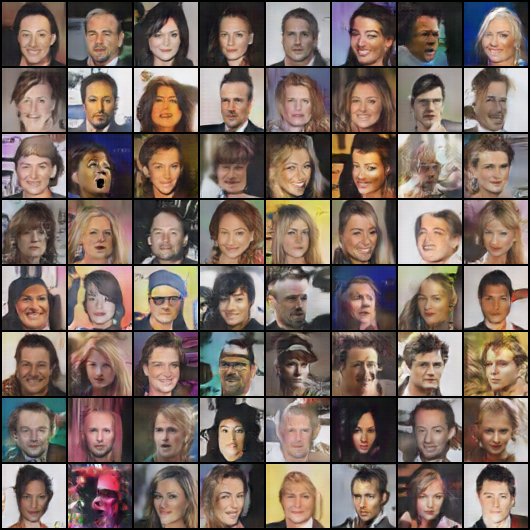

# Evaluation

## Quantitative evaluation

In [16]:
# ─── Linear-probe evaluation (CelebA edition) ───────────────

print("===> Linear-probe evaluation on CelebA (Smiling vs. not)")

# 1) sample your small labelled subset
lab_n = int(len(train_all) * LABEL_FRAC)
lab_idx = np.random.choice(len(train_all), lab_n, replace=False)
train_lab_loader = DataLoader(Subset(train_all, lab_idx),
                              BATCH, shuffle=False)
POOL = nn.AdaptiveMaxPool2d((4,4))

@torch.no_grad()
def feats(loader):
    out, ys = [], []
    for x, y in loader:
        x = x.to(DEVICE)
        h = x
        acts = []
        for layer in netD.main:
            h = layer(h)
            if isinstance(layer, nn.Conv2d) and h.shape[2] >= 4:
                acts.append(POOL(h).cpu())
        feat = torch.cat([a.flatten(1) for a in acts], dim=1)
        out.append(feat)
        ys.append(y)                # y is shape (batch,40)
    X = torch.cat(out).numpy()      # (lab_n, F)
    Y = torch.cat(ys).numpy()      # (lab_n, 40)
    return X, Y

netD.eval()
X_tr_all, Y_tr_all = feats(train_lab_loader)
X_te_all, Y_te_all = feats(test_loader)

# 2) choose one attribute index to predict
SMILING_IDX = 31
y_tr = Y_tr_all[:, SMILING_IDX]
y_te = Y_te_all[:, SMILING_IDX]

# 3) standardize
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_tr = scaler.fit_transform(X_tr_all)
X_te = scaler.transform(X_te_all)

# 4) train & evaluate
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

clf = LogisticRegression(max_iter=1000, n_jobs=-1)
clf.fit(X_tr, y_tr)
acc = accuracy_score(y_te, clf.predict(X_te)) * 100

rep = (f"{datetime.datetime.now()}: "
       f"Linear-probe on ‘Smiling’ "
       f"({LABEL_FRAC:.2%} labels) = {acc:.2f}%\n")
print(rep)
(RES_DIR/"eval.txt").write_text(rep)

===> Linear-probe evaluation on CelebA (Smiling vs. not)


/Users/utkarshgoyal/Desktop/Cornell Tech/3. Spring 2025/specialtopics/CS5996/venv/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: divide by zero encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/utkarshgoyal/Desktop/Cornell Tech/3. Spring 2025/specialtopics/CS5996/venv/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: overflow encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/utkarshgoyal/Desktop/Cornell Tech/3. Spring 2025/specialtopics/CS5996/venv/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: invalid value encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/utkarshgoyal/Desktop/Cornell Tech/3. Spring 2025/specialtopics/CS5996/venv/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:209: RuntimeWarning: divide by zero encountered in matmul
  norm2_w = weights @ weights if weights.ndim == 1 else sq

2025-05-01 09:39:18.479098: Linear-probe on ‘Smiling’ (10.00% labels) = 88.25%



/Users/utkarshgoyal/Desktop/Cornell Tech/3. Spring 2025/specialtopics/CS5996/venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/utkarshgoyal/Desktop/Cornell Tech/3. Spring 2025/specialtopics/CS5996/venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/utkarshgoyal/Desktop/Cornell Tech/3. Spring 2025/specialtopics/CS5996/venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


79

## Qualitative sanity checks

In [12]:
print("===> Qualitative sanity checks")

def latent_interpolation(n_steps=10):
    z0,z1 = torch.randn(1,NZ,1,1,device=DEVICE), torch.randn(1,NZ,1,1,device=DEVICE)
    alphas = torch.linspace(0,1,n_steps,device=DEVICE).view(-1,1,1,1)
    z = z0 + alphas*(z1-z0)
    with torch.no_grad(): imgs = netG(z).cpu()
    vutils.save_image(imgs, RES_DIR/"interpolation.png", nrow=n_steps, normalize=True)

latent_interpolation()

===> Qualitative sanity checks


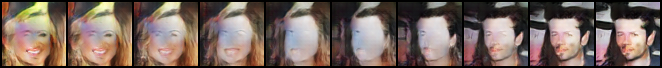

In [13]:
# nearest‑neighbour check
print("  computing nearest neighbours… (may take a minute)")
@torch.no_grad()
def nn_check(num_fake=8, real_subset=6000):
    # sample fakes
    fake = netG(torch.randn(num_fake,NZ,1,1,device=DEVICE)).cpu()
    # prep subset of real images for speed
    sub_idx = np.random.choice(len(train_all), real_subset, False)
    real_subset_imgs = torch.stack([train_all[i][0] for i in sub_idx])  # [R,1,64,64]
    f = fake.view(num_fake,-1)
    r = real_subset_imgs.view(real_subset,-1)
    # compute L2 distances in chunks to save RAM
    nn_real = []
    for v in f:
        dists = ((r - v).pow(2)).sum(1)
        idx = torch.argmin(dists).item()
        nn_real.append(real_subset_imgs[idx])
    grid = torch.cat([fake, torch.stack(nn_real)],0)
    vutils.save_image(grid, RES_DIR/"nearest_neighbour.png", nrow=num_fake, normalize=True)

nn_check()

print("Finished. See result images & logs in", RES_DIR)

  computing nearest neighbours… (may take a minute)
Finished. See result images & logs in results/CelebA


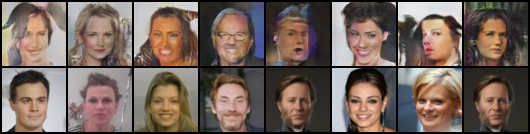